# 한국어 챗봇 만들기

# step1) 필요 패키지 임포트

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# step2) 데이터 다운 및 전처리

## 2-1. 데이터 다운

- 데이터는 질문과 그에 대한 대답과 질문이 어떤 유형인지를 담고 있다.
- label 
    - 0 : 일상 질문 
    - 1 : 부정(이별)
    - 2 : 긍정(사랑)

In [2]:
data_path = os.getenv('HOME')+'/aiffel/enode15/transformer_chatbot/data/ChatbotData.csv'
data = pd.read_csv(data_path)
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [3]:
data.label.unique()

array([0, 1, 2])

- 전체 데이터셋 개수를 확인하자

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


- 데이터 개수가 적어서 전체를 사용해도 될 것 같다.

In [5]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = len(data)
print(MAX_SAMPLES)

11823


## 2-2. 데이터 전처리

- 정규 표현식으로 구두점과 단어 사이 공백을 추가한다.
- 데이터셋에 숫자도 많이 포함되어 있어서 (ex) 1박 2일, 12시) 한글, 숫자, 문장부호를 제외한 다른 문자를 제거하는 전처리 함수를 만들었다.

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 한글과 숫자, 문장부호(".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^0-9ㄱ-ㅎ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

- 영어 데이터의 자료형 역시 list였으므로 데이터 프레임의 각 열에 전처리 함수를 적용한 후 리스트로 변환해서 questions와 answers를 만들자.

In [7]:
questions, answers = list(data['Q'].map(preprocess_sentence)), list(data['A'].map(preprocess_sentence))

In [8]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


실제 전처리된 데이터를 확인해보자.

In [9]:
questions[:3]

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다']

In [10]:
answers[:3]

['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .']

# step3) 단어사전 구축 및 전처리

## 3-1. `tensorflow_datasets.deprecatd.text.SubwordTextEncoder`로 단어사전 구축
- 별도의 한국어 형태소 분석기 사용하지 않고 자체 제작한 토크나이저를 사용한다.
- 말뭉치에서 단어장을 생성해준다.

In [11]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

## 3-2. 단어장에 시작토큰, 종료토큰 추가

- 질문과 답변에서 추출한 단어들로 구축한 단어사전 크기 뒤에 시작 토큰과 종료 토큰을 대신할 정수 값을 지정한다.

In [12]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

- 시작 토큰과 종료 토큰 정수를 고려해 단어사전 크기에 2를 더한다.

In [13]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8160


## 3-3. 단어 정수 인코딩, 패딩

- 텐서플로우로 구축한 토크나이저의 메소드 `encode(sentence)`는 단어사전 안에 있는 문장을 입력하면 정수로 인코딩 해준다.

In [14]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5758, 612, 2486, 4159]
정수 인코딩 후의 21번째 답변 샘플: [2354, 7501, 7, 6265, 97, 1]


- 정수 인코딩에 사용할 최대 길이를 정하기 위해 문장 길이 분포를 확인해보자.

In [15]:
q_len = pd.Series(questions).str.count(' ')
q_len.describe(percentiles=[.25, .75, .99])

count    11823.000000
mean         2.937833
std          1.846075
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
99%          9.000000
max         15.000000
dtype: float64

In [16]:
a_len = pd.Series(answers).str.count(' ')
a_len.describe(percentiles=[.25, .75, .99])

count    11823.000000
mean         3.715301
std          1.925347
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
99%         10.000000
max         23.000000
dtype: float64

In [17]:
q_len[q_len>9]

5362     13
5396     11
5567     11
5772     10
5785     12
8527     10
8601     10
8903     11
8922     10
8930     10
9026     11
9047     10
9167     11
9174     10
9273     13
9276     12
9422     11
9448     10
9471     10
9473     10
9498     10
9506     11
9516     10
9519     11
9662     10
10052    12
10071    11
10175    10
10221    10
10245    12
10263    10
10722    10
10733    10
10870    11
10888    11
10889    11
10958    10
11010    10
11011    12
11044    10
11053    10
11129    10
11186    10
11248    12
11348    10
11451    10
11462    11
11556    11
11626    10
11769    11
11809    10
11810    15
dtype: int64

In [18]:
a_len[a_len>15]

9659     16
9884     18
10258    23
10728    17
10780    17
10808    21
dtype: int64

- 질문과 대답의 최대값은 각각 15 단어, 23 단어였다.
- 질문 데이터의 99%인 9로 자르기에는 9 이상인 데이터의 수가 꽤 있는 것 같아 답변 데이터의 99%인 MAX_LENGTH를 15로 산정해봤다.

In [19]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [20]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 39 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 39으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

In [21]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8160
필터링 후의 질문 샘플 개수: 11573
필터링 후의 답변 샘플 개수: 11573


## 3-4. 데이터 셋 생성
### 교사 강요(`Teacher Forcing`)
- 트랜스포머도 seq2seq 처럼 디코더가 입력받은 문장 행렬로 부터 각 시점의 단어를 예측하도록 훈련

- 교사 강요를 적용해서 데이터셋을 생성한다. 
- 인코더의 입력은 질문의 전체 문장을 입력 받는다.
- 디코더의 입력은 답변의 전체 문장 중 종료 토큰을 제거한다.
- 디코더는 이전 타겟을 다음 입력으로 사용하므로 출력에는 시작 토큰을 제거한 답변을 제공한다.

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

# step4) 모델 도우미 함수

## 4-1. Positional Encoding

- 트랜스포머 모델은 기존 RNN과 달리 문장 전체 행렬을 입력으로 받는다. 그렇기 때문에 문장에서의 순서 정보도 같이 전달해줘야 어떤 단어가 문장의 어느 위치에서 자주  발생하는지 등을 알 수 있다.
포지셔널 인코딩은 모델에게 전체 문장에서 단어의 순서를 알려준다.

In [23]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

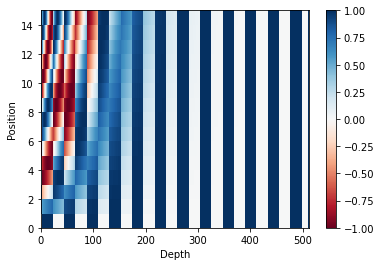

In [190]:
sample_pos_encoding = PositionalEncoding(15, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 4-2. scaled dot product attention

In [189]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

## 4-3. 멀티 헤드 어텐션

- 병렬로 어텐션을 진행한다.
- 모델 생성 시 

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

## 4-4. 마스킹

### 4-4-1. 패딩 마스킹
- 문장 길이를 맞추기 위해 넣었던 패딩 값은 어텐션 연산에 의미가 없다.
- 이를 제외하기 위해 패딩의 위치를 마스킹하자.

In [27]:
# 패딩 마스킹
# 정수 시퀀스 입력 시 0인 부분 체크한 벡터 반환
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

### 4-4-2. 룩 어헤드 마스킹
- 트랜스포머는 기존 RNN과 달리 문장 전체 벡터가 입력으로 들어간다.
- RNN은 각각의 step마다 단어가 들어가므로 단어를 예측할 때 이전 스텝에서 나온 단어들만 참고할 수 있고 이후에 생성될 단어를 참고할 수가 없다.
- 그렇지만 트랜스포머는 전체 문장이 입력으로 들어가므로 지금 예측하는 위치와 상관 없이 모든 단어를 참조할 수 있다.
- 예측해야할 위치 다음에 나오는 단어들은 볼 수 없도록 가리는 룩 어헤드 마스크를 생성하자.

In [28]:
# 룩 어헤드 마스킹
# 역시 패딩 마스킹 필요
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# step5) 모델 구성하기

## 5-1. 인코더 층 구성
- 하나의 인코더 레이어를 구성하는 함수다.
- 멀티 헤드 어텐션 -> Dropout, Layer Normalization -> Dense('relu') -> Dense -> Dropout, Layer Normalization

In [29]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 5-2. 인코더 생성
- 임베딩층과 포지셔널 인코딩과 인코더 층 여러개를 연결해서 하나의 인코더를 만든다.

In [30]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 5-3. 디코더 층 구성

- 하나의 디코더 레이어를 구성하는 함수다.
- 셀프 어텐션 -> LayerNormalization -> 인코더-디코더 어텐션 -> Dropout, LayerNormalization -> Dense('relu') -> Dense -> Dropout, Layer Normalization

In [31]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 5-4. 디코더 생성

- 임베딩 레이어와 포지셔널 인코딩 이후에 앞서 생성한 디코더 층 생성 함수를 이용해 디코더 층 여러개를 이어붙인다.

In [32]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 5-5. 모델 정의

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## 5-6. 모델 생성

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3143168     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

## 5-7. 손실 함수

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

## 5-8. 커스텀 된 학습률

- 초반에 학습률을 크게 설정했다가 점점 학습이 진행되면서 train step이 증가할 수록 학습률을 서서히 낮추는 커스텀 학습률 스케쥴링 방법을 사용하자.

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

- 시각화

Text(0.5, 0, 'Train Step')

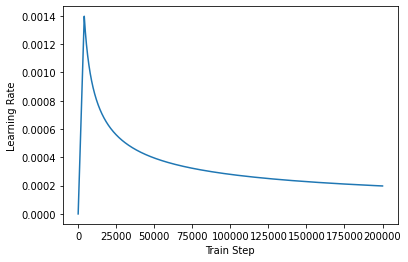

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 5-9. 모델 컴파일

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

## 5-10. 훈련

In [39]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
181/181 [==============================] - 41s 182ms/step - loss: 4.1404 - accuracy: 0.0456
Epoch 2/20
181/181 [==============================] - 38s 208ms/step - loss: 3.3750 - accuracy: 0.1374
Epoch 3/20
181/181 [==============================] - 38s 211ms/step - loss: 2.8006 - accuracy: 0.1398
Epoch 4/20
181/181 [==============================] - 37s 207ms/step - loss: 2.5475 - accuracy: 0.1476
Epoch 5/20
181/181 [==============================] - 39s 214ms/step - loss: 2.3641 - accuracy: 0.1577
Epoch 6/20
181/181 [==============================] - 38s 208ms/step - loss: 2.2270 - accuracy: 0.1679
Epoch 7/20
181/181 [==============================] - 37s 203ms/step - loss: 2.0440 - accuracy: 0.1835
Epoch 8/20
181/181 [==============================] - 38s 208ms/step - loss: 1.8323 - accuracy: 0.2039
Epoch 9/20
181/181 [==============================] - 39s 218ms/step - loss: 1.6345 - accuracy: 0.2299
Epoch 10/20
181/181 [==============================] - 38s 212ms/step - l

- loss가 안정적으로 수렴하는 모습을 볼 수 있다.

# step6) 모델 평가하기
- 입력 문장에 대한 대답을 생성하는 예측 함수를 만들자

In [40]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장.
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [42]:
sentence_generation('졸리다.')

입력 : 졸리다.
출력 : 잠을 깨요 ! 기운 내요 ! !


'잠을 깨요 ! 기운 내요 ! !'

In [43]:
sentence_generation('배고파 죽겠어')

입력 : 배고파 죽겠어
출력 : 얼른 뭐라도 드세요 .


'얼른 뭐라도 드세요 .'

In [44]:
sentence_generation('배고파 죽겠다')

입력 : 배고파 죽겠다
출력 : 얼른 맛난 음식 드세요 .


'얼른 맛난 음식 드세요 .'

In [163]:
sentence_generation('합격했어!')

입력 : 합격했어!
출력 : 좋은 사회생활의 밑거름이 되길 바랍니다 .


'좋은 사회생활의 밑거름이 되길 바랍니다 .'

In [47]:
sentence_generation('내일 기말고사야')

입력 : 내일 기말고사야
출력 : 좋은 결과 있을 거예요 .


'좋은 결과 있을 거예요 .'

In [48]:
sentence_generation('놀고 싶어')

입력 : 놀고 싶어
출력 : 저도요 . 제일 편한거 같아요 .


'저도요 . 제일 편한거 같아요 .'

In [49]:
sentence_generation('심심해')

입력 : 심심해
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

In [50]:
sentence_generation('심심하다고')

입력 : 심심하다고
출력 : 친구들과 연락해보세요 .


'친구들과 연락해보세요 .'

- 띄어쓰기가 달라도 특이한 주요 키워드가 포함되어있으면 똑같은 답변을 내놓는다.

In [56]:
sentence_generation('교직이수 하고 싶어')

입력 : 교직이수 하고 싶어
출력 : 학점 관리하세요 .


'학점 관리하세요 .'

In [57]:
sentence_generation('교직이수 하고싶어')

입력 : 교직이수 하고싶어
출력 : 학점 관리하세요 .


'학점 관리하세요 .'

In [175]:
sentence_generation('교직이수 하기 싫어')

입력 : 교직이수 하기 싫어
출력 : 학점 관리하세요 .


'학점 관리하세요 .'

In [59]:
sentence_generation('재밌는 거 뭐 없을까')

입력 : 재밌는 거 뭐 없을까
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

In [60]:
sentence_generation('맛집 알려줘')

입력 : 맛집 알려줘
출력 : 벌써 먹고 싶어요 .


'벌써 먹고 싶어요 .'

In [62]:
sentence_generation('졸려')

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [63]:
sentence_generation('치킨 먹고 싶어')

입력 : 치킨 먹고 싶어
출력 : 맛있게 드세요 .


'맛있게 드세요 .'

In [64]:
sentence_generation('허리 아파')

입력 : 허리 아파
출력 : 운동 해보는 것도 좋을 거예요 .


'운동 해보는 것도 좋을 거예요 .'

In [65]:
sentence_generation('마카롱 먹고 싶어')

입력 : 마카롱 먹고 싶어
출력 : 비싸지만 맛있어요 .


'비싸지만 맛있어요 .'

In [95]:
sentence_generation('꺼져')

입력 : 꺼져
출력 : 충전하고 만나요 .


'충전하고 만나요 .'

In [67]:
sentence_generation('어떻게 나한테 이래')

입력 : 어떻게 나한테 이래
출력 : 힘들만해요 .


'힘들만해요 .'

In [69]:
sentence_generation('피자 먹고 싶어')

입력 : 피자 먹고 싶어
출력 : 같이 먹어주죠 .


'같이 먹어주죠 .'

In [100]:
sentence_generation('나 내일 시험이야')

입력 : 나 내일 시험이야
출력 : 컨디션 조절 하세요 .


'컨디션 조절 하세요 .'

In [165]:
sentence_generation('비가 엄청 온다')

입력 : 비가 엄청 온다
출력 : 비 맞으면 안돼요 !


'비 맞으면 안돼요 !'

In [72]:
sentence_generation('뭔가 술이 땡기네')

입력 : 뭔가 술이 땡기네
출력 : 혹시 전화를 한 건 아니길 바랍니다 .


'혹시 전화를 한 건 아니길 바랍니다 .'

In [73]:
sentence_generation('술 마시고 싶다')

입력 : 술 마시고 싶다
출력 : 저랑 한 잔 해요 .


'저랑 한 잔 해요 .'

In [76]:
sentence_generation('카페인 중독인가봐')

입력 : 카페인 중독인가봐
출력 : 핑계예요 .


'핑계예요 .'

In [77]:
sentence_generation('꿀꿀하네')

입력 : 꿀꿀하네
출력 : 더 괜찮아 지려고 하는 과정일 거예요 .


'더 괜찮아 지려고 하는 과정일 거예요 .'

In [78]:
sentence_generation('졸업했다!')

입력 : 졸업했다!
출력 : 졸업 축하해요


'졸업 축하해요'

In [80]:
sentence_generation('귀가 간지러워')

입력 : 귀가 간지러워
출력 : 누가 욕하고 있나봐요 .


'누가 욕하고 있나봐요 .'

In [81]:
sentence_generation('오늘 같은 날엔')

입력 : 오늘 같은 날엔
출력 : 축하드려요 .


'축하드려요 .'

In [84]:
sentence_generation('공부하기 싫어')

입력 : 공부하기 싫어
출력 : 잠시 쉬어도 괜찮아요 .


'잠시 쉬어도 괜찮아요 .'

In [86]:
sentence_generation('막걸리엔 파전')

입력 : 막걸리엔 파전
출력 : 뭐 좀 챙겨드세요 .


'뭐 좀 챙겨드세요 .'

- 원본 데이터셋과 비슷한 말인 것 같은데도 중간중간 부사어나 어미에 따라 다른 대답을 했다.

In [88]:
sentence_generation('치매가 심해지고 있어')

입력 : 치매가 심해지고 있어
출력 : 무서운 소리 마세요 .


'무서운 소리 마세요 .'

In [89]:
sentence_generation('치매가 점점 심해지는 거 같아')

입력 : 치매가 점점 심해지는 거 같아
출력 : 더 많이 연락하고 관심을 가져주세요 .


'더 많이 연락하고 관심을 가져주세요 .'

In [90]:
data[data.Q.str[:2]=='치매']

,Q,A,label
4575,치매가 더 심해지는 것 같아 무서워,더 많이 연락하고 관심을 가져주세요.,0
4576,치매가 점점 심해지는 거 같아,더 많이 연락하고 관심을 가져주세요.,0
4577,치매이면 어쩌지,무서운 소리 마세요.,0
4578,치매일까봐 무섭다.,무서운 소리 마세요.,0


In [99]:
sentence_generation('미쳤냐')

입력 : 미쳤냐
출력 : 그럴 수 있어요 .


'그럴 수 있어요 .'

In [101]:
sentence_generation('화가 나')

입력 : 화가 나
출력 : 저에게 화를 덜어보세요 .


'저에게 화를 덜어보세요 .'

In [102]:
sentence_generation('졸려')

입력 : 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [104]:
sentence_generation('빙수가 먹고 싶어')

입력 : 빙수가 먹고 싶어
출력 : 디저트는 언제나 맛있어요 .


'디저트는 언제나 맛있어요 .'

In [105]:
sentence_generation('빙수는 항상 옳아')

입력 : 빙수는 항상 옳아
출력 : 디져트 드세요 .


'디져트 드세요 .'

In [106]:
sentence_generation('어젯밤 세상이 무너졌어')

입력 : 어젯밤 세상이 무너졌어
출력 : 어떤 꿈이었나요 .


'어떤 꿈이었나요 .'

In [112]:
sentence_generation('울어도 돼')

입력 : 울어도 돼
출력 : 저에게 기대세요 .


'저에게 기대세요 .'

In [113]:
sentence_generation('산책 하자')

입력 : 산책 하자
출력 : 안해도 괜찮을 거예요


'안해도 괜찮을 거예요'

In [191]:
sentence_generation('산책 갈까?')

입력 : 산책 갈까?
출력 : 안해도 괜찮을 거예요


'안해도 괜찮을 거예요'

In [114]:
sentence_generation('어머님은 짜장면이 싫다고 하셨어')

입력 : 어머님은 짜장면이 싫다고 하셨어
출력 : 요즘 예민한가봐요 .


'요즘 예민한가봐요 .'

In [117]:
sentence_generation('한강 가자')

입력 : 한강 가자
출력 : 야근이 만든 야경이죠 .


'야근이 만든 야경이죠 .'

In [122]:
data[data['Q'].str[:2]=='한강']

,Q,A,label
5009,한강 가서 맥주 마시고 싶다.,분위기도 맛도 다 좋겠네요.,0
5010,한강 밤에 가면 좋겠지?,야근이 만든 야경이죠.,0
5011,한강 야경 좋지?,야근이 만든 야경이죠.,0
5012,한강에서 맥주 캬,분위기도 맛도 다 좋겠네요.,0
8425,한강에서 소주한잔.,분위기 있네요.,1


In [177]:
sentence_generation('마음이 아프네')

입력 : 마음이 아프네
출력 : 지쳐서 그런가봐요 .


'지쳐서 그런가봐요 .'

In [125]:
sentence_generation('어떻게 나한테 이래')

입력 : 어떻게 나한테 이래
출력 : 힘들만해요 .


'힘들만해요 .'

- 이렇게 하나의 키워드만 걸리면 같은 응답을 하는 경우도 보였다.

In [126]:
sentence_generation('새 옷을 샀어')

입력 : 새 옷을 샀어
출력 : 깔끔한 스타일이 좋을 것 같습니다 .


'깔끔한 스타일이 좋을 것 같습니다 .'

In [127]:
sentence_generation('오늘 무슨 옷을 입을까?')

입력 : 오늘 무슨 옷을 입을까?
출력 : 깔끔한 스타일이 좋을 것 같습니다 .


'깔끔한 스타일이 좋을 것 같습니다 .'

- 비슷한 맥락의 말인데도 꽤 다른 응답을 보여주기도 했다.

In [128]:
sentence_generation('화나')

입력 : 화나
출력 : 결국 시간은 흐르고 일상으로 돌아갈 거예요 .


'결국 시간은 흐르고 일상으로 돌아갈 거예요 .'

In [129]:
sentence_generation('화가 나')

입력 : 화가 나
출력 : 저에게 화를 덜어보세요 .


'저에게 화를 덜어보세요 .'

In [130]:
sentence_generation('재밌는 거 뭐 없을까?')

입력 : 재밌는 거 뭐 없을까?
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

In [131]:
sentence_generation('정답을 알려줘')

입력 : 정답을 알려줘
출력 : 답은 언제나 내 안에 있죠 .


'답은 언제나 내 안에 있죠 .'

In [132]:
sentence_generation('맛집 추천 좀')

입력 : 맛집 추천 좀
출력 : 벌써 먹고 싶어요 .


'벌써 먹고 싶어요 .'

In [136]:
sentence_generation('어떻게 나한테 이래')

입력 : 어떻게 나한테 이래
출력 : 힘들만해요 .


'힘들만해요 .'

In [140]:
sentence_generation('비가 엄청 온다')

입력 : 비가 엄청 온다
출력 : 비 맞으면 안돼요 !


'비 맞으면 안돼요 !'

In [143]:
sentence_generation('출근길 너무 힘들어')

입력 : 출근길 너무 힘들어
출력 : 회사 근처로 이사를 가보세요 .


'회사 근처로 이사를 가보세요 .'

In [147]:
sentence_generation('카페인 중독인가봐')

입력 : 카페인 중독인가봐
출력 : 핑계예요 .


'핑계예요 .'

In [151]:
sentence_generation('머리가 아파')

입력 : 머리가 아파
출력 : 병원에 가야죠 .


'병원에 가야죠 .'

In [152]:
sentence_generation('꿀꿀하네')

입력 : 꿀꿀하네
출력 : 더 괜찮아 지려고 하는 과정일 거예요 .


'더 괜찮아 지려고 하는 과정일 거예요 .'

In [153]:
sentence_generation('졸업했다!')

입력 : 졸업했다!
출력 : 졸업 축하해요


'졸업 축하해요'

In [154]:
sentence_generation('귀가 간지러워')

입력 : 귀가 간지러워
출력 : 누가 욕하고 있나봐요 .


'누가 욕하고 있나봐요 .'

In [185]:
sentence_generation('요즘따라 슬픈 일이 자꾸 생각나')

입력 : 요즘따라 슬픈 일이 자꾸 생각나
출력 : 무슨 일이 있었나봐요 .


'무슨 일이 있었나봐요 .'

In [179]:
sentence_generation('')

입력 : 
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

In [186]:
sentence_generation('매번 작심삼일')

입력 : 매번 작심삼일
출력 : 모든 일에도 후회가 남기 마련이지요 .


'모든 일에도 후회가 남기 마련이지요 .'

- 왜 그냥 작심삼일에... 이렇게 말하는 걸까

In [187]:
sentence_generation('작심삼일')

입력 : 작심삼일
출력 : 이별에 척도를 두지 말아요 .


'이별에 척도를 두지 말아요 .'

In [188]:
data[data.A.str.contains('이별에 척도를 두지 말아요')]

,Q,A,label
6935,어떤 작별일지,이별에 척도를 두지 말아요.,1


In [179]:
sentence_generation('')

입력 : 
출력 : 지금은 힘들겠지만 조금만 더 견뎌봐요 .


'지금은 힘들겠지만 조금만 더 견뎌봐요 .'

# 회고
- 생각보다 상황에 적절한 말을 내뱉는 모습을 볼 수 있었다.
- 어차피 패딩 마스크를 사용해서 MAX_LENGTH가 데이터셋 최대 단어 수 이상 인 경우 숫자가 좀 달라진다고 해도 별 차이가 없을 것이라고 생각했는데 최대 단어 수인 23을 넘겨서 39, 40으로 지정한 두 경우간에 문장 생성 결과도 꽤 달라졌다.
    - 인퍼런스 함수에서 MAX_LENGTH를 한 번 더 반복하는게 그만큼 큰 의미가 있었나..
- 타이트하게 MAX_LENGTH를 주었는데 생각보다 결과가 잘 나왔다.
- 자주 나오지 않는 키워드는 원본 답변과 계속 같은 말만 반복했다.
- 미묘한 어조 차이에 따라서 답변이 달라지는 모습을 볼 수 있었다.
- 아직까지 트랜스포머의 성능을 올리기 위해서 어떤 튜닝을 할 수 있는지 확실히 감이 오지는 않는 것 같다. 조금 더 다양한 사례를 공부해 봐야겠다.